In [180]:
import pandas as pd

import plotly.offline as py

py.init_notebook_mode(connected=True)


In [181]:
cases_per_country_df = pd.read_csv('./dataset/country_wise_latest.csv')
daily_cases_df = pd.read_csv('./dataset/day_wise.csv')
cases_per_country_df.rename(
    columns={
        'Country/Region': 'country',
        'New cases': 'new_cases',
        'New deaths': 'new_deaths',
        'New recovered': 'new_recovered',
        'Deaths / 100 Cases': 'deaths_100_cases',
        'Recovered / 100 Cases': 'recovered_100_cases',
        'Confirmed last week': 'confirmed_last_week',
        '1 week change': '1_week_change',
        '1 week_%_increase': '1_week_increase_percent'
        , 'WHO Region': 'WHO_region'
    },
    inplace=True)

In [182]:
countries = cases_per_country_df['country']
confirmed = cases_per_country_df['Confirmed']
recovered = cases_per_country_df['Recovered']
deaths = cases_per_country_df['Deaths']
confirmed_data = dict(
    type='choropleth',
    locations=countries,
    z=confirmed,
    colorscale='Rainbow',
    locationmode='country names',
    text=countries,
    showscale=True,
    marker=dict(
        line=dict(color='rgb(100,100,100)', width=1)),
    colorbar=dict(autotick=True, tickprefix='',
                  title='Covid Cases by Count ')
)

layout = dict(
    title='Covid 19 Cases by Country',
    geo=dict(
        showframe=False,
        showocean=True,
        oceancolor='rgb(28,109,160)',
        projection=dict(
            type='orthographic',
            rotation=dict(
                lon=60,
                lat=10),
        ),
        lonaxis=dict(
            showgrid=True,
            gridcolor='rgb(255, 255, 255)'
        ),
        lataxis=dict(
            showgrid=True,
            gridcolor='rgb(255, 255, 255)'
        )
    ),
)
fig = dict(data=[confirmed_data], layout=layout)
py.iplot(fig, validate=False)

# Convert to recovered
recovered_data = confirmed_data.copy()
recovered_data["z"]=recovered
recovered_data["colorscale"]="Blues"
recovered_data["colorbar"]=confirmed_data["colorbar"]
recovered_data["colorbar"]["title"]="Covid Recovered Cases Count"
recovered_layout = layout.copy()
recovered_layout["title"] = "Covid 19 Recovered Cases by Country"
recovered_fig = dict(data=[recovered_data], layout=recovered_layout)
py.iplot(recovered_fig, validate=False)

# Convert to deaths
deaths_data = confirmed_data.copy()
deaths_data["z"]=deaths
deaths_data["colorscale"]="Reds"
deaths_data["colorbar"]=confirmed_data["colorbar"]
deaths_data["colorbar"]["title"]="Covid Deaths Count"
deaths_layout = layout.copy()
deaths_layout["title"] = "Covid 19 Deaths by Country"
deaths_fig = dict(data=[deaths_data], layout=deaths_layout)
py.iplot(deaths_fig, validate=False)

In [183]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_cases_df['Date'], y=daily_cases_df['Active'],
                    mode='lines',
                    name='Active'))
fig.add_trace(go.Scatter(x=daily_cases_df['Date'], y=daily_cases_df['Recovered'],
                    mode='lines',
                    name='Recovered'))
fig.add_trace(go.Scatter(x=daily_cases_df['Date'], y=daily_cases_df['Deaths'],
                         mode='lines',
                         name='Deaths'))
fig.update_layout(title =  "Active/Recovered/Deaths timeline of 2020",
                  barmode = 'group', title_font_size = 30)
fig.update_xaxes(title_text = 'Date')
fig.update_yaxes(title_text = "Count")

fig.show()

14:39:08 - cmdstanpy - INFO - Chain [1] start processing
14:39:08 - cmdstanpy - INFO - Chain [1] done processing


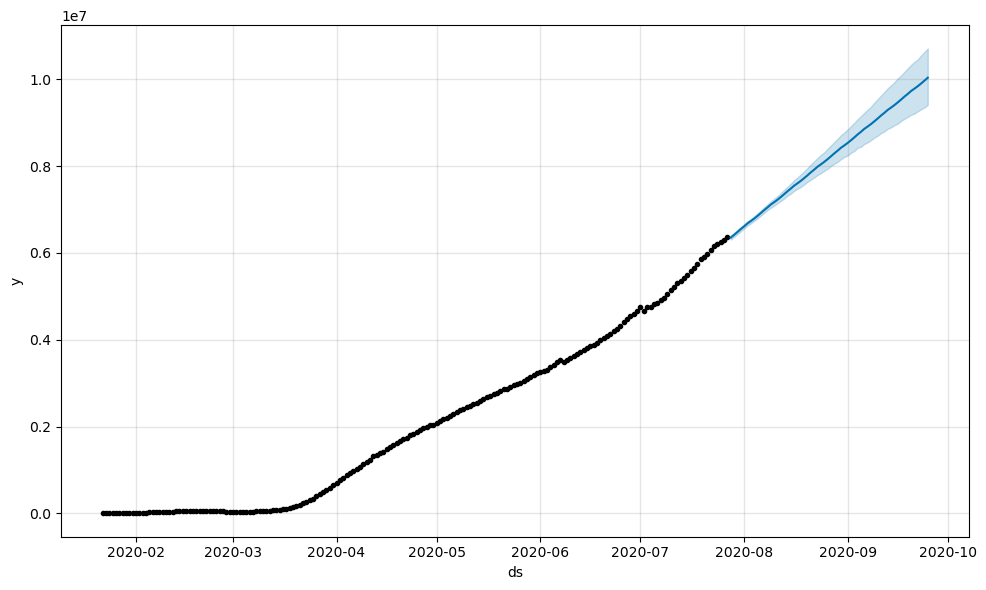

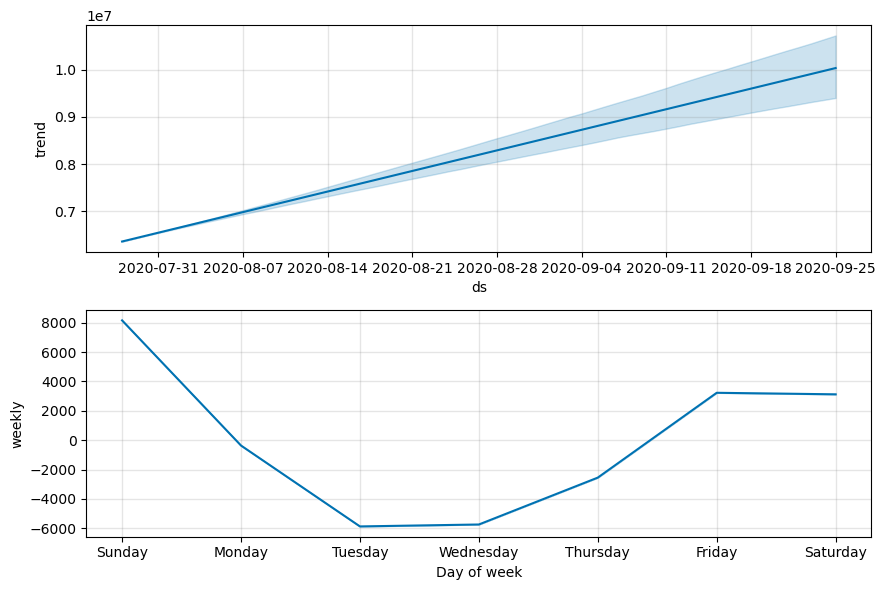

In [185]:
from prophet import Prophet
import plotly.graph_objects as go


conf_data = daily_cases_df[['Date', 'Active']].groupby('Date', as_index = False).sum()
conf_data.columns = ['ds', 'y']
conf_data.ds = pd.to_datetime(conf_data.ds)
conf_data.head()


proph = Prophet()
proph.fit(conf_data)


# Make forecast and cut only the predicted values, not the actual ones we have
prediction_dataframe = proph.make_future_dataframe(periods=60)
# Get only predictions for dates later than 2020-07-27
confirmed_forecast = proph.predict(prediction_dataframe)[188:]

# Plot data
fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_cases_df['Date'], y=daily_cases_df['Active'],
                         mode='lines',
                         name='Active'))
fig.add_trace(go.Scatter(x=confirmed_forecast['ds'], y=confirmed_forecast['yhat'],
                         mode='lines',
                         name='Predicted Active'))

case_predictions = proph.plot(confirmed_forecast)
fig2 = proph.plot_components(confirmed_forecast)
fig.update_layout(title =  "Active/Predicted timeline of 2020",
                  barmode = 'group', title_font_size = 30)
fig.update_xaxes(title_text = 'Date')
fig.update_yaxes(title_text = "Count")

fig.show()
